In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, ConvLSTM2D, Flatten, MaxPooling1D, Conv1D, TimeDistributed
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

2024-06-17 06:44:49.496589: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 06:44:49.507082: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 06:44:49.627621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 06:44:51.622189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('data.csv', index_col='DATE', parse_dates=True)

In [3]:
df.head()

,GH_ID,TMPMAX,TMPMIN,PERCIPT
DATE,,,,
1990-01-01,ARABOM11,26.100000,13.800000,7.400000
1990-01-01,WOCOMB32,23.600000,10.800000,20.900000
1990-01-01,BAGINI31,23.600000,11.900000,5.900000
1990-01-01,SHEJAJ31,26.855887,11.387372,17.467829
1990-01-01,SHDEBR11,19.000000,3.100000,0.000000


In [4]:
features = ['PERCIPT', 'TMPMAX', 'TMPMIN']
targets = ['PERCIPT', 'TMPMAX', 'TMPMIN']


In [5]:
df_grouped = df.groupby('GH_ID')

In [6]:
GH_ID  = list(df_grouped.groups.keys())[0]
data = df_grouped.get_group(GH_ID)[features]
data.head()

,PERCIPT,TMPMAX,TMPMIN
DATE,,,
1990-01-01,7.400000,26.1,13.8
1990-02-01,347.400000,24.8,15.8
1990-03-01,186.100000,24.8,15.8
1990-04-01,183.500000,26.3,16.0
1990-05-01,124.117738,30.1,17.5


In [7]:
data

,PERCIPT,TMPMAX,TMPMIN
DATE,,,
1990-01-01,7.400000,26.100000,13.800000
1990-02-01,347.400000,24.800000,15.800000
1990-03-01,186.100000,24.800000,15.800000
1990-04-01,183.500000,26.300000,16.000000
1990-05-01,124.117738,30.100000,17.500000
...,...,...,...
2022-08-01,212.385449,24.344199,14.084097
2022-09-01,140.342006,25.272176,13.678442
2022-10-01,85.735158,25.846927,12.694649


In [8]:
train = np.array(data.iloc[:int(len(data)*0.8)])
test = np.array(data.iloc[int(len(data)*0.8):])

train.shape, test.shape

((316, 3), (80, 3))

In [9]:
train[0:2]

array([[  7.4,  26.1,  13.8],
       [347.4,  24.8,  15.8]])

In [10]:
n_input = 12
n_features = 3

train_generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(test, test, length=n_input, batch_size=1)

In [11]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(n_input, n_features))))
model.add(Dense(n_features))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [12]:
# Train the model
history = model.fit(train_generator, 
          epochs=50, 
          validation_data=test_generator,  
          callbacks=[EarlyStopping(monitor='loss', patience=5)])

Epoch 1/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 1449.2180 - mse: 1449.2180 - val_loss: 1146.7738 - val_mse: 1146.7738
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1023.0474 - mse: 1023.0474 - val_loss: 1255.5507 - val_mse: 1255.5507
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 1202.0134 - mse: 1202.0134 - val_loss: 1109.9308 - val_mse: 1109.9308
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 992.4109 - mse: 992.4109 - val_loss: 1150.0333 - val_mse: 1150.0333
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1017.4017 - mse: 1017.4017 - val_loss: 1137.1055 - val_mse: 1137.1055
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 895.3251 - mse: 895.3251 - val_loss: 1616.2031 - val_mse: 1616.2031
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1596.8301 - mse: 1596.8301 - val_loss: 1296.1583 - val_mse: 1296.1583
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1031.5741 - mse: 1031.5741

In [13]:
# Evaluate the model on validation data
val_loss, val_mse = model.evaluate(test_generator)

print(f"Validation Loss: {val_loss}")
print(f"Validation MSE: {val_mse}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 982.8231 - mse: 982.8231
Validation Loss: 947.9310913085938
Validation MSE: 947.9310913085938


Text(0.5, 1.0, 'loss per epoch for vanilla LSTM')

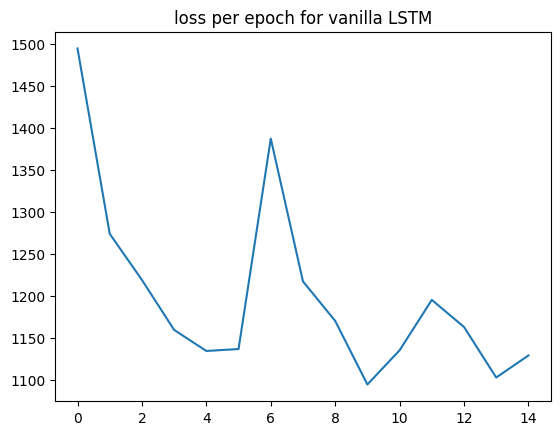

In [14]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.title(f'loss per epoch for bidirectional LSTM')